In [1]:
# ============================================================================
# TRABAJO PRACTICO FINAL - ARBOL DE DECISION - TITANIC
# Sistemas de Soporte para la Toma de Decisiones
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# ============================================================================
# 1. CARGA DE DATOS
# ============================================================================

print("="*80)
print("1. CARGANDO DATOS DEL TITANIC")
print("="*80)

# Rutas de los archivos
ruta_train = r"C:\Users\santi\OneDrive\Desktop\Quinto año\Sistema de soporte para la toma de decisiones\Trabajos practicos\train.csv"
ruta_test = r"C:\Users\santi\OneDrive\Desktop\Quinto año\Sistema de soporte para la toma de decisiones\Trabajos practicos\test.csv"

# Cargar datasets
df_train = pd.read_csv(ruta_train)
df_test = pd.read_csv(ruta_test)

print(f"\nDimensiones del conjunto de entrenamiento: {df_train.shape}")
print(f"Dimensiones del conjunto de prueba: {df_test.shape}")

print("\nInformacion general del dataset:")
print(df_train.info())


1. CARGANDO DATOS DEL TITANIC

Dimensiones del conjunto de entrenamiento: (891, 12)
Dimensiones del conjunto de prueba: (418, 11)

Informacion general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None



2. ANALISIS EXPLORATORIO DE DATOS

Valores faltantes en train:
Age         177
Cabin       687
Embarked      2
dtype: int64

Valores faltantes en test:
Age       86
Fare       1
Cabin    327
dtype: int64

Estadisticas descriptivas:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min     

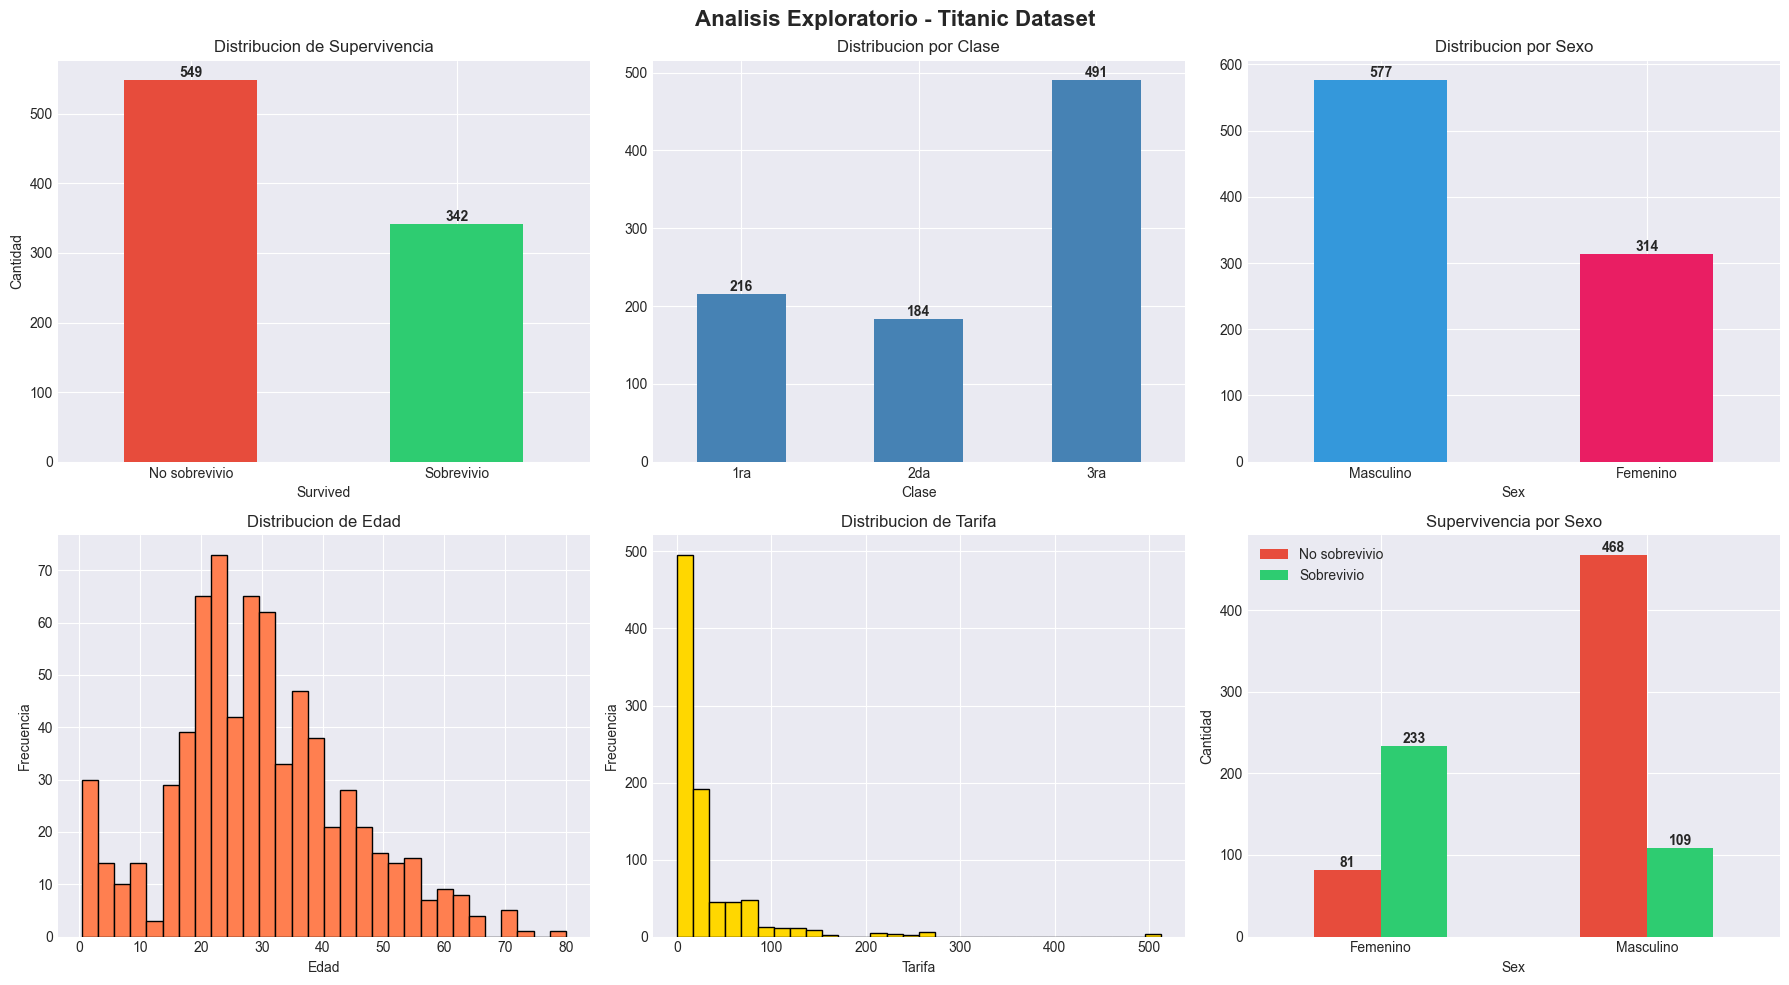

In [3]:
# ============================================================================
# 2. ANALISIS EXPLORATORIO DE DATOS (EDA)
# ============================================================================

print("\n" + "="*80)
print("2. ANALISIS EXPLORATORIO DE DATOS")
print("="*80)

# Valores faltantes
print("\nValores faltantes en train:")
missing_train = df_train.isnull().sum()
print(missing_train[missing_train > 0])

print("\nValores faltantes en test:")
missing_test = df_test.isnull().sum()
print(missing_test[missing_test > 0])

# Estadisticas descriptivas
print("\nEstadisticas descriptivas:")
print(df_train.describe())

# Distribucion de la variable objetivo
print("\nDistribucion de Survived:")
print(df_train['Survived'].value_counts())
print(f"Tasa de supervivencia: {df_train['Survived'].mean()*100:.2f}%")

# Graficos EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Analisis Exploratorio - Titanic Dataset', fontsize=16, fontweight='bold')

# Survived
df_train['Survived'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#e74c3c', '#2ecc71'])
axes[0,0].set_title('Distribucion de Supervivencia')
axes[0,0].set_xticklabels(['No sobrevivio', 'Sobrevivio'], rotation=0)
axes[0,0].set_ylabel('Cantidad')
for container in axes[0,0].containers:
    axes[0,0].bar_label(container, fmt='%d', fontsize=10, fontweight='bold')

# Pclass
df_train['Pclass'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='steelblue')
axes[0,1].set_title('Distribucion por Clase')
axes[0,1].set_xlabel('Clase')
axes[0,1].set_xticklabels(['1ra', '2da', '3ra'], rotation=0)
for container in axes[0,1].containers:
    axes[0,1].bar_label(container, fmt='%d', fontsize=10, fontweight='bold')

# Sex
df_train['Sex'].value_counts().plot(kind='bar', ax=axes[0,2], color=['#3498db', '#e91e63'])
axes[0,2].set_title('Distribucion por Sexo')
axes[0,2].set_xticklabels(['Masculino', 'Femenino'], rotation=0)
for container in axes[0,2].containers:
    axes[0,2].bar_label(container, fmt='%d', fontsize=10, fontweight='bold')

# Age
df_train['Age'].hist(bins=30, ax=axes[1,0], color='coral', edgecolor='black')
axes[1,0].set_title('Distribucion de Edad')
axes[1,0].set_xlabel('Edad')
axes[1,0].set_ylabel('Frecuencia')

# Fare
df_train['Fare'].hist(bins=30, ax=axes[1,1], color='gold', edgecolor='black')
axes[1,1].set_title('Distribucion de Tarifa')
axes[1,1].set_xlabel('Tarifa')
axes[1,1].set_ylabel('Frecuencia')

# Survived by Sex
pd.crosstab(df_train['Sex'], df_train['Survived']).plot(kind='bar', ax=axes[1,2], 
                                                          color=['#e74c3c', '#2ecc71'])
axes[1,2].set_title('Supervivencia por Sexo')
axes[1,2].set_xticklabels(['Femenino', 'Masculino'], rotation=0)
axes[1,2].set_ylabel('Cantidad')
axes[1,2].legend(['No sobrevivio', 'Sobrevivio'])
for container in axes[1,2].containers:
    axes[1,2].bar_label(container, fmt='%d', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('01_eda_titanic.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# ============================================================================
# 3. PREPROCESAMIENTO DE DATOS
# ============================================================================

print("\n" + "="*80)
print("3. PREPROCESAMIENTO DE DATOS")
print("="*80)

def preprocesar_datos(df, es_train=True):
    """
    Preprocesa el dataset del Titanic aplicando:
    - Imputacion de valores faltantes
    - Feature engineering
    - Codificacion de variables categoricas
    """
    df = df.copy()
    
    # ----- FEATURE ENGINEERING -----
    print("\nFeature Engineering...")
    
    # 1. Extraer Titulo del nombre
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Agrupar titulos raros
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna('Rare')
    
    # 2. FamilySize = SibSp + Parch + 1
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # 3. IsAlone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 4. Extraer Deck de Cabin
    df['Deck'] = df['Cabin'].str[0]
    df['Deck'] = df['Deck'].fillna('Missing')
    
    # ----- IMPUTACION DE VALORES FALTANTES -----
    print("\nImputando valores faltantes...")
    
    # Age: Mediana por Pclass y Sex
    for pclass in df['Pclass'].unique():
        for sex in df['Sex'].unique():
            mask = (df['Pclass'] == pclass) & (df['Sex'] == sex) & (df['Age'].isnull())
            median_age = df[(df['Pclass'] == pclass) & (df['Sex'] == sex)]['Age'].median()
            df.loc[mask, 'Age'] = median_age
    
    # Embarked: Moda
    if df['Embarked'].isnull().sum() > 0:
        df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # Fare: Mediana (solo en test tiene 1 nulo)
    if df['Fare'].isnull().sum() > 0:
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # ----- CODIFICACION DE VARIABLES CATEGORICAS -----
    print("\nCodificando variables categoricas...")
    
    # Sex: Label Encoding (male=1, female=0)
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
    
    # Embarked: One-Hot Encoding
    df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', drop_first=True)
    
    # Title: One-Hot Encoding
    df = pd.get_dummies(df, columns=['Title'], prefix='Title', drop_first=True)
    
    # Deck: One-Hot Encoding
    df = pd.get_dummies(df, columns=['Deck'], prefix='Deck', drop_first=True)
    
    # ----- ELIMINAR COLUMNAS INNECESARIAS -----
    columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    if not es_train:
        columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    print(f"\nShape despues del preprocesamiento: {df.shape}")
    print(f"Columnas finales: {list(df.columns)}")
    
    return df

# Aplicar preprocesamiento
df_train_prep = preprocesar_datos(df_train, es_train=True)
df_test_prep = preprocesar_datos(df_test, es_train=False)

# Alinear columnas entre train y test
missing_cols = set(df_train_prep.columns) - set(df_test_prep.columns) - {'Survived'}
for col in missing_cols:
    df_test_prep[col] = 0

df_test_prep = df_test_prep[df_train_prep.drop('Survived', axis=1).columns]

print("\nPreprocesamiento completado")
print(f"Train shape: {df_train_prep.shape}")
print(f"Test shape: {df_test_prep.shape}")



3. PREPROCESAMIENTO DE DATOS

Feature Engineering...

Imputando valores faltantes...

Codificando variables categoricas...

Shape despues del preprocesamiento: (891, 23)
Columnas finales: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Missing', 'Deck_T']

Feature Engineering...

Imputando valores faltantes...

Codificando variables categoricas...

Shape despues del preprocesamiento: (418, 21)
Columnas finales: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Missing']

Preprocesamiento completado
Train shape: (891, 23)
Test shape: (418, 22)
